# Voxel Based Morphometry (VBM) analysis with FSL


This notebook is an edited version of the FSL-VBM tutorial to match what we will cover during GOGNESTIC. The full official FSL course tutorials, as well as the FSL-VBM user’s guide, are available here:

https://fsl.fmrib.ox.ac.uk/fslcourse/2019_Beijing/lectures/Structural/seg_struct.html

https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSLVBM/UserGuide


## FSL-VBM for group comparison

In this session we look at a small ageing study comparing two groups (data_2groups, young and older healthy controls) for local differences in grey matter volume, using FSL-VBM. We will also look at another ageing dataset (data_Age) to see how we can use FSL-VBM to look for correlations between grey matter volume and a continuous measure (age, cognitive test score, etc). Most of the steps have already been carried out, as there isn't enough time in this session to run all of the registrations required to carry out a full analysis from scratch, but you can re-run these later in your own time. 

## FSL-VBM Pipeline - Overview

Running FSL-VBM involves a few simple steps: 

*	prepare your T1-weighted images in the right format 
*	fslvbm_1_bet - carry out brain extraction on all T1 images 
*	fslvbm_2_template - create the study-specific symmetric grey matter template 
*	fslvbm_3_proc - register all the grey matter images to the template, modulate and smooth them with different kernel sizes and finally runs an initial GLM analysis for qualitative evaluation 
*	randomise - carry out voxelwise GLM analysis using permutation testing 


## Step 1 - Prepare your data for the FSL-VBM study

#### A. Place all your T1-weighted data in your FSL-VBM directory. 

Start by creating a new directory, and then copy into your FSL-VBM directory all of your subjects' T1 images, giving each subject's T1 image a different name, preferably with a prefix corresponding to each group. **This step has already been carried out for this tutorial.**  




In [2]:
#import general modules
import os
import glob
import subprocess

#set up paths
notebook_dir = "/home/cognestic/COGNESTIC/03_Structural_MRI/FSLVBM/notebooks"
data_dir = "/home/cognestic/COGNESTIC/03_Structural_MRI/FSLVBM/data"
vbm_dir = f"{data_dir}/data_2groups/FSLVBM"

#list the T1 files in FSLVBM directory
T1_files = glob.glob(f"{vbm_dir}/*_T1.nii.gz")

for item in T1_files:
    print(item[-23:])


YNG_CBU111197_T1.nii.gz
OLD_CBU111032_T1.nii.gz
OLD_CBU110653_T1.nii.gz
OLD_CBU111054_T1.nii.gz
OLD_CBU110866_T1.nii.gz
YNG_CBU110871_T1.nii.gz
OLD_CBU110519_T1.nii.gz
YNG_CBU110854_T1.nii.gz
YNG_CBU110752_T1.nii.gz
YNG_CBU120057_T1.nii.gz
OLD_CBU110220_T1.nii.gz
YNG_CBU110799_T1.nii.gz
YNG_CBU111009_T1.nii.gz
YNG_CBU110547_T1.nii.gz
OLD_CBU111154_T1.nii.gz
YNG_CBU111116_T1.nii.gz
OLD_CBU120017_T1.nii.gz
YNG_CBU110468_T1.nii.gz
OLD_CBU110970_T1.nii.gz
OLD_CBU110819_T1.nii.gz


#### B. Select subjects to create a study-specific template. 

If you have more than one group and the number of subjects in each is not the same, choose (at random) among the biggest group(s) the images that you will use to create the study-specific template, with the same number as of the smallest group (in order to create an unbiased template - see below for further explanation). Once you've chosen which T1 images to keep to build the template, put all the selected names of exams in a file called template_list in your FSL-VBM directory.

All your different populations included in this study MUST be represented in the template construction. 

If you are using all datasets, simply run the following: 

In [3]:
output_file = f"{vbm_dir}/template_list"

with open(output_file, "w") as file:
    for item in T1_files:
        file.write(f"{item[-23:]}\n")

#### C. Check your data

At this point you should have a quick look at all your data to check that all subjects' structural images are what you expected. The slicesdir command takes the list of images and creates a simple web-page containing snapshots for each of the images. Once it has finished running it tells you the name of the web page to open in your web browser, to view the snapshots. Have a careful look. 

In [11]:
#change to vbm directory
os.chdir(vbm_dir)

#check if a slicesdir folder exists within the fslvbm directory, which would suggest that the slicesdir command has been run
slicesdir_path = f"{vbm_dir}/slicesdir"

#if slicesdir has not been run, run it to inspect the FA data
if not os.path.exists(slicesdir_path):

    #run slicesdir to inspect the T1 data

    #set up the command
    command = "slicesdir *.nii.gz"

    # Execute the command
    try:
        result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        html_file = [f for f in os.listdir(f"{vbm_dir}/slicesdir") if f.endswith('.html')]
        print(f"slicesdir completed successfully. To visualise the output, open the following link in your browser: http://{vbm_dir}/slicesdir/{html_file[0]}")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")
        print("Output:\n", e.stdout)
        print("Errors:\n", e.stderr)



#### D. Create your design matrix and contrast files

It is a good idea to consider your cross-subject statistical model before you run the FSL-VBM analysis. So you should at this point create your design.mat and design.con in your FSL-VBM directory; see some FSL GLM examples here https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM. For simple experimental design with just two groups you can also use the script design_ttest2:

In [10]:
#creat the design matrix and contrast files for comparing two groups of 10 pariticpants each 
command = "design_ttest2 design 10 10"

# Execute the command
try:
    result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print('design_ttest2 completed successfully.')
except subprocess.CalledProcessError as e:
    print(f"An error occurred: {e}")
    print("Output:\n", e.stdout)
    print("Errors:\n", e.stderr)

   

design_ttest2 completed successfully.


WARNING!!! The order of the rows in your design.mat model MUST match the order of your images in the FSL-VBM directory (alphabetical order). 

## Step 2 - Extracting brain information: fslvbm_1_bet

The first FSL-VBM script moves all your input images into a new struc subdirectory (and adding "_struc" to the end of each filename). It then runs brain extraction on the images. You can either use the -b option to get default BET behaviour, or use the -N option if your images include a lot of neck (which most of the time confounds the BET preprocessing). 

In [12]:
#change to vbm directory
os.chdir(vbm_dir)

#check if a struct folder exists within the fslvbm directory, which would suggest that the fslvbm_1_bet command has been run
struc_path = f"{vbm_dir}/struc"

#if fslvbm_1_bet has not been run, run it now 
if not os.path.exists(struc_path):

    #run fslvbm_1_bet

    #set up the command
    command = "fslvbm_1_bet -N"

    # Execute the command
    try:
        result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print('fslvbm_1_bet completed successfully.')
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")
        print("Output:\n", e.stdout)
        print("Errors:\n", e.stderr)


#### LOOK AT YOUR DATA

At the end of this step, it is once again worth CHECKING the brain images (*_brain.*) in your struc directory by loading the new slicesdir output into a web browser. Brain extraction is the step which is the most likely to need tweaking in the FSL-VBM protocol. It might not be too much of an issue if you get "more" than the grey matter (eyes, dura etc.) though this will need careful checking before running your statistics. If you do not get good results with either option (i.e., if some images are missing some grey matter), you can try adding other bet options after the -b or -N option. 

If you later want to add more subjects to your analysis then just put the new subjects' images inside the top level directory (e.g. FSLVBM) and re-run fslvbm_1_bet. Don't forget to update template_list if necessary. 



## Step 3 - Creating the template: fslvbm_2_template

The second step of the FSL-VBM protocol creates the study-specific grey matter (GM) template. 

First, all brain-extracted images are segmented into GM, WM and CSF. Then, GM images selected in the template_list file (*_struc_GM) are affine-registered to the GM ICBM-152 template, concatenated and averaged. This averaged image is then flipped along the x-axis and the two mirror images then re-averaged to obtain a first-pass, study-specific "affine" GM template ("template_GM_init"). Second, the template_list GM images are re-registered to this "affine" GM template using non-linear registration, concatenated into a 4D image called "template_4D_GM", averaged, flipped along the x-axis. Both mirror images are then averaged to create the final symmetric, study-specific "non-linear" GM template at 2x2x2mm<sup>3</sup> resolution in standard space.

If you have different populations, they should all be represented in your template. You should use the same number of subjects from each in the construction of the study-specific template. This is to avoid any bias during the registration step that would have consisted in favouring one of the groups. For example, if you have only controls in your template, or more controls than patients, it is likely that the non-linear registration would be more accurate for your control subjects than for your patients. Then you cannot distinguish, in your results showing differences in the GM volume distribution between the two groups, what is actually disease-related from what is registration-related! 

For this step, you have two options: either you want to create a template based on an affine registration (-a option) of GM images to the GM ICBM-152 template, or on a non-linear registration (-n option). The non-linear (-n) option is usually recommended. 


In [13]:
#change to vbm directory
os.chdir(vbm_dir)

#check if the file template_GM.nii.gz exists within the fslvbm/struc directory, which would suggest that the fslvbm_2_template command has been run
template_path = f"{vbm_dir}/struc/template_GM.nii.gz"

#if tbss_2_template has not been run, run it now
if not os.path.exists(template_path):

    #run fslvbm_2_template

    #set up the command
    command = f"fslvbm_2_template -n"

    # Execute the command
    try:
        result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print('fslvbm_2_template completed successfully.')
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")
        print("Output:\n", e.stdout)
        print("Errors:\n", e.stderr)

Once this is completed, we can check the template_GM.nii.gz image in the struc folder: 

Text(0.5, 1.0, 'GM template, sagittal view')

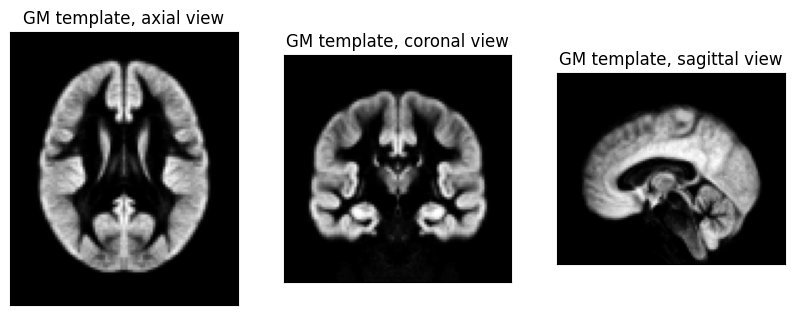

In [14]:
from nilearn import image
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

#load the GM template
GM_template = image.load_img(f"{vbm_dir}/struc/template_GM.nii.gz")
GM_template_data = GM_template.get_fdata()

#set up the subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

axes[0].imshow(rotate(GM_template_data[:,:,46], -90), cmap='gray', origin='lower')
axes[0].set_title("GM template, axial view")

axes[1].imshow(rotate(GM_template_data[:,54,:], -90), cmap='gray', origin='lower')
axes[1].set_title("GM template, coronal view")

axes[2].imshow(rotate(GM_template_data[46,:,:], -90), cmap='gray', origin='lower')
axes[2].set_title("GM template, sagittal view")


## Step 4 - Processing the native GM images: fslvbm_3_proc

The final script will non-linearly register all your GM images to the study-specific template and concatenate them into a 4D image ("GM_merg") in the stats directory in your working FSL-VBM directory. 

The FSL-VBM protocol also introduces a compensation (or "modulation") for the contraction/enlargement due to the non-linear component of the transformation: each voxel of each registered grey matter image is multiplied by the Jacobian of the warp field (see Good et al., 2001). All the modulated registered GM images are concatenated into a 4D image in the stats directory ("GM_mod_merg") and then smoothed ("GM_mod_merg_s3" for instance) by a range of Gaussian kernels; sigma = 2, 3, 4mm, i.e., approximately from FWHM = 2x2.3 = 4.6mm to FWHM = 9mm.

Finally, this last step gets everything ready for you to run permutation-based non-parametric inference using the design.mat and design.con which you supplied, a mask of the GM ("GM_mask") and the 4D multi-subject concatenated processed data (e.g. "GM_mod_merg_s3"). The script runs randomise with inference (generation of p-value maps) turned off, so that it very quickly creates just the raw tstat maps. These tstats maps should help you decide which smoothing is the most relevant to feed into a full run of randomise, and which threshold to use for the cluster-based thresholding (option -c in the randomise command); however, in general we would recommend using the TFCE option (-T) instead of the cluster-based thresholding. 

WARNING!!! By default fslvbm_3_proc concatenates the images in alphabetical order (following the names that they started with); make sure this matches the subject ordering assumed in your design.mat model.


In [15]:
#change to vbm directory
os.chdir(vbm_dir)

#check if the directory stats exists within the fslvbm directory, which would suggest that the fslvbm_3_proc command has been run
stats_path = f"{vbm_dir}/stats"

#if tbss_3_proc has not been run, run it now
if not os.path.exists(stats_path):

    #run fslvbm_3_proc

    #set up the command
    command = "fslvbm_3_proc"

    # Execute the command
    try:
        result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print('fslvbm_3_proc completed successfully.')
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")
        print("Output:\n", e.stdout)
        print("Errors:\n", e.stderr)

## Step 5 - Obtaining and displaying your FSL-VBM results

We strongly recommend using randomise (permutation testing) for inference in VBM-style analysis and not Gaussian random field theory (GRF), as the approximations underlying the latter are not generally appropriate in such analyses. For more detail see the Randomise manual https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Randomise/UserGuide.

### Choosing the level of smoothing

Before running randomise for permutation testing, we need to choose the most appropriate smoothing (e.g., sigma=3mm) for the TFCE-based analysis. 

#### Why smoothing?

Smoothing makes it harder to interpret the results because it will average the signal over neighbouring voxelx, leading to a local GM average density. However, there are some statistical benefits:

1. Smoothing compensates for some spatial registration error; it helps to accommodate individual differences in brain anatomy that might not be perfectly aligned even after spatial normalization.

2. Increased statistical power: smothing supresses noise (as long as the signal of interest is not smoothed out).

#### How much smoothing should be applied?

1. There is no right answer. 
 
2. Check different levels, to see what is consistent and present at all levels of smoothing.

3. Decide what is best for your data:
    
    * For larger areas, the results will be more sensitive with more smoothing applied.

    * If smaller biologically plausible areas can be seen on t-maps, then less smoothing would be better.

    * The ammount of smoothing changes the relative sensitivity of the methods to different ized regions. 

4. Always report and justify the level of smoothing used for every publication. 

To help you decide between smoothing levels, you can loook at the output from fslvbm_3_proc:

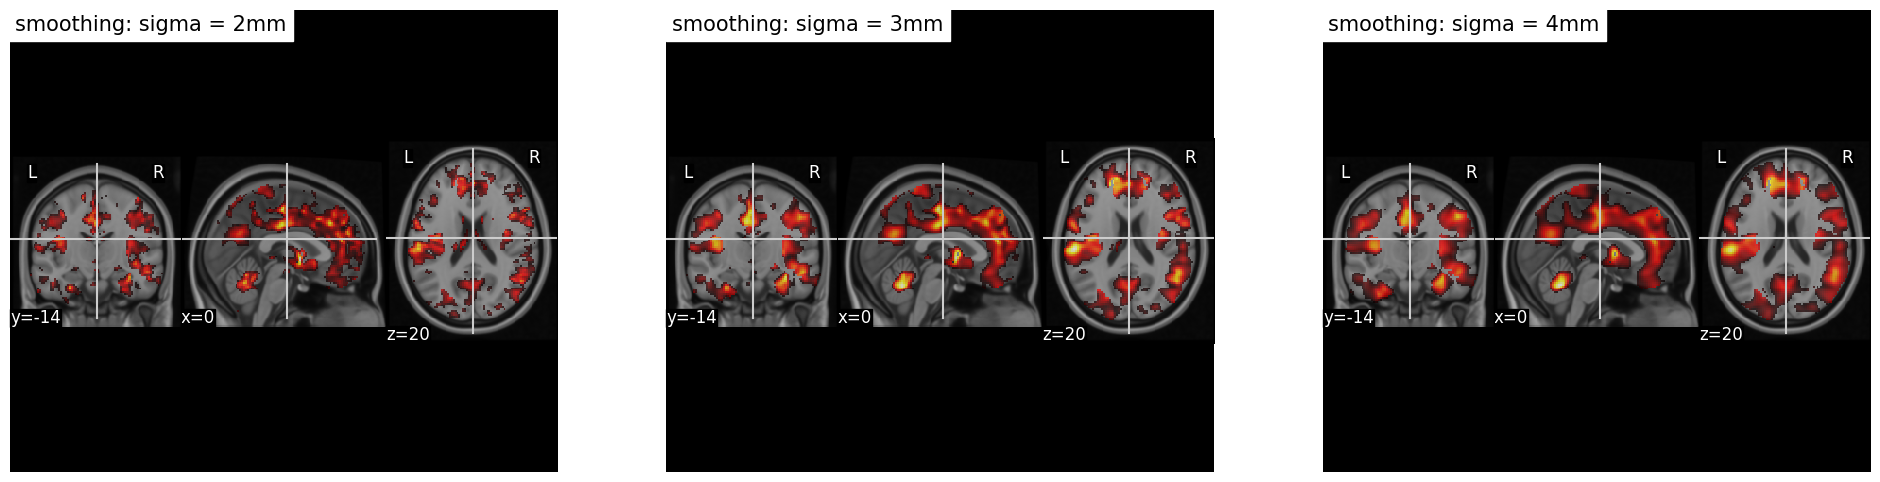

In [16]:
#look at the different smoothing levels

#import the modules required for visualisation
import numpy as np
from nilearn import image, plotting

#path to FSLDIR
fsldir_path = os.environ.get('FSLDIR')

#load images
background_img = image.load_img(f"{fsldir_path}/data/standard/MNI152_T1_1mm.nii.gz")
s2_img = image.load_img(f"{vbm_dir}/stats/GM_mod_merg_s2_tstat2.nii.gz")
s3_img = image.load_img(f"{vbm_dir}/stats/GM_mod_merg_s3_tstat2.nii.gz")
s4_img = image.load_img(f"{vbm_dir}/stats/GM_mod_merg_s4_tstat2.nii.gz")

#theshold the t-maps maps to show only values between 3 and 16
data_s2 = s2_img.get_fdata()
thresholded_data_s2 = np.where((data_s2 >= 2) & (data_s2 <= 16), data_s2, 0)
data_s3 = s3_img.get_fdata()
thresholded_data_s3 = np.where((data_s3 >= 2) & (data_s3 <= 16), data_s3, 0)
data_s4 = s4_img.get_fdata()
thresholded_data_s4 = np.where((data_s4 >= 2) & (data_s4 <= 16), data_s4, 0)

# Create a new Nilearn image object with the thresholded data
thresholded_img_s2 = image.new_img_like(s2_img, thresholded_data_s2)
thresholded_img_s3 = image.new_img_like(s3_img, thresholded_data_s3)
thresholded_img_s4 = image.new_img_like(s4_img, thresholded_data_s4)

# Plotting the background image with the overlays

fig, axes = plt.subplots(1, 3, figsize=(24, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

display1 = plotting.plot_anat(background_img, display_mode='ortho', axes=axes[0], title='smoothing: sigma = 2mm')
display1.add_overlay(thresholded_img_s2, cmap=plt.cm.hot, alpha=0.7)  # Using 'hot' colormap

display2 = plotting.plot_anat(background_img, display_mode='ortho', axes=axes[1], title='smoothing: sigma = 3mm')
display2.add_overlay(thresholded_img_s3, cmap=plt.cm.hot, alpha=0.7)  # Using 'hot' colormap

display3 = plotting.plot_anat(background_img, display_mode='ortho', axes=axes[2], title='smoothing: sigma = 4mm')
display3.add_overlay(thresholded_img_s4, cmap=plt.cm.hot, alpha=0.7)  # Using 'hot' colormap

# Show the plot
plt.show()

If you want to apply a different smoothing than already applied, you can do so (e.g., sigma=3.5mm) using fslmaths: 

In [18]:
#change into the stats directory
os.chdir(f"{vbm_dir}/stats")

#set up the command to apply smoothing with sigma = 3.5mm
command = "fslmaths GM_mod_merg -s 3.5 GM_mod_merg_s3.5"

# Execute the command
try:
    result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print('Smoothing applied successfully.')
except subprocess.CalledProcessError as e:
    print(f"An error occurred: {e}")
    print("Output:\n", e.stdout)
    print("Errors:\n", e.stderr)

Smoothing applied successfully.


### Running randomise and displaying TFCE-based thresholding results

Having chosen the most appropriate smoothing (e.g. sigma = 3mm), run permutation testing with randomise. Typically you would run 5000 permutations, but in the interest of time we will run just 500:

In [19]:
#change into the stats directory
os.chdir(f"{vbm_dir}/stats")

#check if the fslvbm_tfce_corrp_tstat1.nii.gz file exists within the fslvbm/stats directory, which would suggest that the randomise step has been run 
corrp_file_path = f"{vbm_dir}/stats/fslvbm_tfce_corrp_tstat1.nii.gz"

#if the skeletonised data does not exist, run randomise
if not os.path.exists(corrp_file_path):

    #set up the command to run randomise with 500 permutations
    command = (
        f'randomise -i GM_mod_merg_s3 '
        f'-o fslvbm '
        f'-m GM_mask '
        f'-d design.mat '
        f'-t design.con '
        f'-n 500 '
        f'-T ' 
    )

    # Execute the command
    try:
        result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print('randomise completed successfully.')
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")
        print("Output:\n", e.stdout)
        print("Errors:\n", e.stderr)

Contrast 1 gives the GM(old) > GM(young) test. The raw unthresholded tstat image is fslvbm_tstat1 and the corresponding (p-values corrected for multiple comparisons) cluster image is fslvbm_tfce_corrp_tstat1.

Thresholding clusters at 0.95 (corresponding to thresholding the p-values at 0.05, because randomise outputs p-values as 1-p for convenience of display - so that higher values are more significant). The following shows the corrected significant values in red-yellow:

/cognestic/miniconda3/envs/mri/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)
/cognestic/miniconda3/envs/mri/lib/python3.11/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


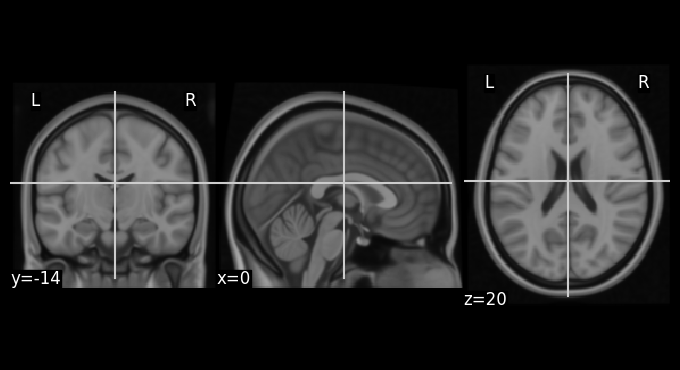

In [20]:
# Load the images
background_img = image.load_img(f"{fsldir_path}/data/standard/MNI152_T1_1mm.nii.gz")
overlay_img = image.load_img(f"{vbm_dir}/stats/fslvbm_tfce_corrp_tstat1.nii.gz")

#theshold the significance map to show only values between 0.95 and 1 to keep only significant voxels
data = overlay_img.get_fdata()
thresholded_data = np.where((data >= 0.95) & (data <= 1), data, 0)

# Create a new Nilearn image object with the thresholded data
thresholded_img = image.new_img_like(overlay_img, thresholded_data)

# Plotting the background image with the overlay
display = plotting.plot_anat(background_img, display_mode='ortho')
display.add_overlay(thresholded_img, cmap=plt.cm.hot, alpha=0.7)  # Using 'hot' colormap

# Show the plot
plt.show()

We do not see any red-yellow in the plot above, which means that there are no significant clusters for contrast 1. This is in line with the expectations from the literature, which suggests GM volume generally decreaeses with age. Contrast 2 gives the GM(old) < GM(young) test, and the figure below shows the corrected significant values in green-blue:

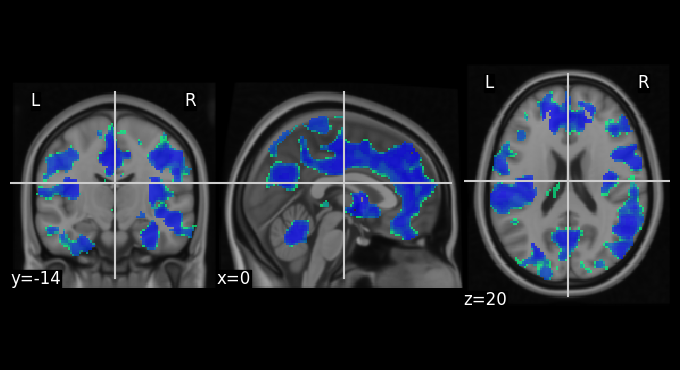

In [21]:
# Load the overlay image
overlay_img = image.load_img(f"{vbm_dir}/stats/fslvbm_tfce_corrp_tstat2.nii.gz")

#theshold the significance map to show only values between 0.95 and 1 to keep only significant voxels
data = overlay_img.get_fdata()
thresholded_data = np.where((data >= 0.95) & (data <= 1), data, 0)

# Create a new Nilearn image object with the thresholded data
thresholded_img = image.new_img_like(overlay_img, thresholded_data)

# Plotting the background image with the overlay
display = plotting.plot_anat(background_img, display_mode='ortho')
display.add_overlay(thresholded_img, cmap=plt.cm.winter_r, alpha=0.7)  # Using 'winter' colormap

# Show the plot
plt.show()

This simple group analysis reveals widespread decline of GM density with age, which is in line with previous reports in the Ageing literature.  